This Python code translates the R code (the example_acm.R)  The code creates a scatter plot that displays an adaptive comfort model based on the ASHRAE Global Thermal Comfort Database II. The plot shows the relationship between outdoor temperature and neutral temperature for different building cooling types: Air Conditioned, Mixed Mode, and Naturally Ventilated. </br>

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from matplotlib.ticker import FormatStrFormatter


In [19]:
# Read metadata from Github
url_meta = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_metadata.csv"
df_meta = pd.read_csv(url_meta)

# Read database from Github
url_measurements = "https://github.com/CenterForTheBuiltEnvironment/ashrae-db-II/raw/master/v2.1.0/db_measurements_v2.1.0.csv.gz"
df_measurements = pd.read_csv(url_measurements)

/Users/ruijisun/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
df_measurements

,index,record_id,building_id,timestamp,season,subject_id,age,gender,ht,wt,...,rh_out,t_out_monthly,t_out_isd,rh_out_isd,set,pmv,ppd,pmv_ce,ppd_ce,t_mot_isd
0,0,1,1,1995-05-18T00:00:00Z,winter,10.0,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,28.1,0.50,10.2,0.38,8.0,17.4
1,1,2,1,1995-05-18T00:00:00Z,winter,14.0,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,27.2,0.40,8.4,0.40,8.4,17.4
2,2,3,1,1995-05-18T00:00:00Z,winter,15.0,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,24.8,-0.07,5.1,-0.07,5.1,17.4
3,3,4,1,1995-05-18T00:00:00Z,winter,17.0,NaN,female,NaN,NaN,...,99.1,NaN,16.295833,86.837514,25.5,0.31,7.0,0.14,5.4,17.4
4,4,5,1,1995-05-18T00:00:00Z,winter,21.0,NaN,male,NaN,NaN,...,99.1,NaN,16.295833,86.837514,26.0,0.05,5.0,-0.06,5.1,17.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109028,110065,110066,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109029,110066,110067,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109030,110067,110068,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0
109031,110068,110069,809,2014-06-02T00:00:00Z,hot/wet,NaN,NaN,NaN,NaN,NaN,...,NaN,28.8,28.316667,82.059739,NaN,NaN,NaN,NaN,NaN,28.0


To conduct adaptive thermal model analysis, we need concurrent observations of indoor air temperature, thermal sensation vote, and outdoor mean monthly temperature. However, here here the orignial R code (Python version) also requires relative humidity data.

In [21]:
# remove nan values in Ta, thermal_sensation, and t_out_isd or t_out
df_acm = df_measurements.loc[(~df_measurements['ta'].isna()) &
                              (~df_measurements['thermal_sensation'].isna()) &
                              (~df_measurements['rh'].isna()) &
                              (~(df_measurements['t_out_isd'].isna()) | ~(df_measurements['t_out'].isna()))].copy()
print('number of rows that have required data for acm:', len(df_acm))
print('number of buildings that have required data for acm:', len(df_acm.building_id.unique()))

# Fill the missing values in the outdoor temperature column
df_acm.loc[:, 't_out_combined'] = df_acm.loc[:, 't_out_isd'].fillna(df_acm.loc[:, 't_out'])

# Remove original temperature columns
df_acm = df_acm.drop(columns=['t_out_isd', 't_out'])

# Merge metadata and databased by office buildings
df_acm = df_acm.merge(df_meta[['building_id', 'region', 'building_type', 'cooling_type', 'records']], on='building_id', how='left')
df_acm = df_acm[df_acm['building_type'] == 'office']
df_acm = df_acm.drop(columns=['building_type'])
print('number of office buildings that have required data for acm:', len(df_acm.building_id.unique()))
print('number of rows (office) that have required data for acm:', len(df_acm))


number of rows that have required data for acm: 74701
number of buildings that have required data for acm: 732
number of office buildings that have required data for acm: 304
number of rows (office) that have required data for acm: 49584


The orginal R code evalue the p-value of intercept

In [22]:
# Calculate the neutral temperature for each building
def run_lm(bldg):
    try:
        lm_result = smf.ols(formula='ta ~ thermal_sensation', data=bldg).fit()
        # check whether the slope is significant
        if lm_result.pvalues['Intercept'] < 0.05:
            return lm_result.params['Intercept']
        else:
            return np.nan
    except (ValueError, TypeError):
        return np.nan

df_models = df_acm.groupby('building_id').apply(run_lm).reset_index()
df_models.columns = ['building_id', 'neutral_temp']
df_models = df_models.merge(df_meta[['building_id', 'records', 'cooling_type', 'region']], on='building_id', how='left')
df_models['t_out_mean'] = df_acm.groupby('building_id')['t_out_combined'].mean().values
# get rid of all nan values in the neutral_temp column
df_models = df_models[~df_models['neutral_temp'].isna()]
df_models


,building_id,neutral_temp,records,cooling_type,region,t_out_mean
0,1,22.585738,170,mixed mode,oceania,15.296857
1,2,22.058339,83,air conditioned,oceania,13.995833
2,3,23.142187,85,air conditioned,americas,0.583480
3,4,23.642083,137,mixed mode,oceania,19.284220
4,5,22.071788,128,air conditioned,americas,9.048210
...,...,...,...,...,...,...
299,763,20.837842,134,naturally ventilated,europe,9.983256
300,771,23.439683,161,air conditioned,europe,15.119837
301,772,23.082808,94,air conditioned,europe,2.571260
302,779,28.210619,118,air conditioned,asia,28.855652


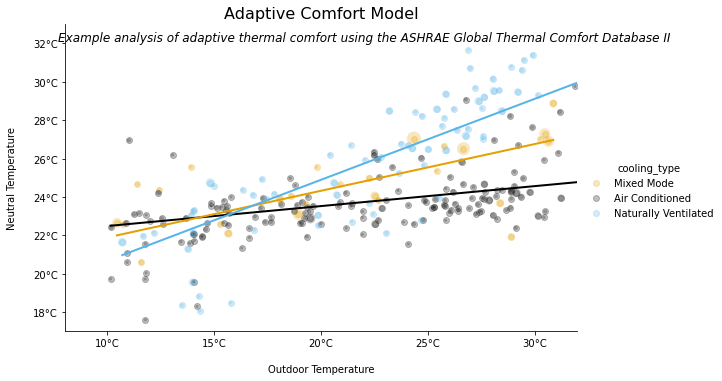

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import statsmodels.formula.api as smf

# Assuming filtered_df is already loaded and filtered

# Define a custom function to draw the weighted regression line
def weighted_regression_line(x, model):
    return model.params[0] + model.params[1] * x

colors = {"Air Conditioned": "#000000", "Mixed Mode": "#E69F00", "Naturally Ventilated": "#56B4E9"}

lm = sns.lmplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                palette=colors, scatter_kws={'alpha': 0.25}, 
                height=5, aspect=1.6, fit_reg=False)

# Add point_size directly to the scatterplot
sns.scatterplot(data=filtered_df, x='t_out_mean', y='neutral_temp', hue='cooling_type', 
                size='point_size', sizes=(10, 200), legend=False, 
                palette=colors, alpha=0.25, ax=lm.ax)

# Fit weighted linear regression and plot the lines for each cooling_type
for cooling_type, color in colors.items():
    sub_df = filtered_df[filtered_df['cooling_type'] == cooling_type]
    wlm = smf.wls(formula='neutral_temp ~ t_out_mean', data=sub_df, weights=sub_df['point_size']).fit()
    x_values = np.linspace(sub_df['t_out_mean'].min(), sub_df['t_out_mean'].max(), 100)
    y_values = weighted_regression_line(x_values, wlm)
    lm.ax.plot(x_values, y_values, color=color, linewidth=2)

lm.ax.set_xlim(8, 32)
lm.ax.set_ylim(17, 33)
lm.ax.set_xlabel('\nOutdoor Temperature')
lm.ax.set_ylabel('Neutral Temperature\n')
lm.ax.xaxis.set_major_formatter(FormatStrFormatter('%d°C'))
lm.ax.yaxis.set_major_formatter(FormatStrFormatter('%d°C'))

# Annotations
lm.ax.annotate("Lower 80%", xy=(33.7, 24.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Lower 90%", xy=(33.7, 25.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 90%", xy=(33.7, 28.0), xycoords='data', fontsize=10, color='grey', fontstyle='italic')
lm.ax.annotate("Upper 80%", xy=(33.7, 30.5), xycoords='data', fontsize=10, color='grey', fontstyle='italic')


plt.title('Adaptive Comfort Model', fontsize=16)
plt.suptitle('Example analysis of adaptive thermal comfort using the ASHRAE Global Thermal Comfort Database II', fontsize=12, fontstyle='italic', y=0.95)
plt.show()

Regression results for natural ventilated buildings

In [29]:
# Filter the data for naturally ventilated buildings
naturally_ventilated = df_models[df_models['cooling_type'] == 'naturally ventilated']

# Run weighted linear regression between neutral_temp and t_out_mean
lm_w_nv = smf.ols(formula='neutral_temp ~ t_out_mean', weights=naturally_ventilated.records, data=naturally_ventilated).fit()

# Print the summary of the linear regression
print(lm_w_nv.summary())


                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 4.675e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):          2.73e-118
Time:                        11:32:21   Log-Likelihood:                -204.03
No. Observations:                  87   AIC:                             412.1
Df Residuals:                      85   BIC:                             417.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.8851      0.820     19.380      0.0

Regression results for mixed mode buildings

In [28]:
# Filter the data for mix mode buildings
mixed_mode = df_models[df_models['cooling_type'] == 'mixed mode']

# Run linear regression between neutral_temp and t_out_mean
lm_w_mm = smf.ols(formula='neutral_temp ~ t_out_mean', weights=mixed_mode.records, data=mixed_mode).fit()

# Print the summary of the linear regression
print(lm_w_mm.summary())

                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.935e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):           3.84e-45
Time:                        11:32:11   Log-Likelihood:                -54.866
No. Observations:                  31   AIC:                             113.7
Df Residuals:                      29   BIC:                             116.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.2096      0.700     30.292      0.0

Regression results for air_conditioned buildings

In [27]:
# Filter the data for naturally ventilated buildings
air_conditioned = df_models[df_models['cooling_type'] == 'air conditioned']

# Run linear regression between neutral_temp and t_out_mean
lm_w_ac = smf.ols(formula='neutral_temp ~ t_out_mean', weights=air_conditioned.records, data=air_conditioned).fit()

# Print the summary of the linear regression
print(lm_w_ac.summary())

                            OLS Regression Results                            
Dep. Variable:           neutral_temp   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.117e+04
Date:                Thu, 04 May 2023   Prob (F-statistic):          6.22e-164
Time:                        11:31:54   Log-Likelihood:                -362.29
No. Observations:                 182   AIC:                             728.6
Df Residuals:                     180   BIC:                             735.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4932      0.232     96.981      0.0